In [1]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git 
!pip install opencv-python
!pip install plot_keras_history

  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\husey\appdata\local\temp\pip-req-build-y1wgnc1c
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101669 sha256=70e9f60e533fe976d1173d80f25def9a82dacce87446bb7cf91ff79172ad17e0
  Stored in directory: C:\Users\husey\AppData\Local\Temp\pip-ephem-wheel-cache-mr1__p0s\wheels\67\d2\f4\96ae3c3c62d1e05abfc8860ad0c1207794726d44ebbbb547f3
Successfully built keras-contrib


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers  import Activation, Conv2D, Input, Dropout, LeakyReLU, Input, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization 
from random import random, randint
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

In [3]:
def discriminatorModel(imageShape):
    model = Sequential()
    model.add(Input(shape=imageShape))
    model.add(Conv2D(64, (4, 4), strides=(2,2), padding='same',input_shape=imageShape))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, (4, 4), strides=(2,2), padding='same'))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512, (4, 4), strides=(1,1), padding='same'))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Conv2D(1, (4,4)))
    # We need to slow down the rate at which the descriminator learns
    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='mse', metrics=['accuracy'],loss_weights=[0.5])
    return model
model = discriminatorModel((256,256,3))    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
instance_normalization (Inst (None, 128, 128, 64)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       5

C:\Users\husey\anaconda3\envs\tf\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [4]:
def residualBlock(LNumberofFilters, LInputLayer):
    resTensor = Conv2D(LNumberofFilters, (3,3), padding='same')(LInputLayer)
    resTensor =InstanceNormalization(axis=-1)(resTensor)
    resTensor = Activation('relu')(resTensor)
    resTensor = Conv2D(LNumberofFilters, (3,3), padding='same')(resTensor)
    resTensor =InstanceNormalization(axis=-1)(resTensor)
    resTensor = Concatenate()([resTensor, LInputLayer])
    return resTensor

In [5]:
def generatorModel(LImageShape, LResnet=9):
    LInputShape = Input(shape=LImageShape)
    genTensor = Conv2D(64, (7,7), padding = 'same',)(LInputShape)
    genTensor = InstanceNormalization(axis=-1)(genTensor)
    genTensor = Activation('relu')(genTensor)
    genTensor = Conv2D(128, (3,3), strides = (2,2), padding = 'same')(genTensor)
    genTensor = InstanceNormalization(axis=-1)(genTensor)
    genTensor = Activation('relu')(genTensor)
    genTensor = Conv2D(258, (3,3), strides = (2,2), padding = 'same')(genTensor)
    genTensor = InstanceNormalization(axis=-1)(genTensor)
    genTensor = Activation('relu')(genTensor)
    
    for _ in range(LResnet):
        genTensor = residualBlock(256, genTensor)
    
    genTensor = Conv2DTranspose(128, (3,3), strides = (2,2), padding = 'same')(genTensor)
    genTensor = InstanceNormalization(axis=-1)(genTensor)
    genTensor = Conv2DTranspose(64, (3,3), strides = (2,2), padding = 'same')(genTensor)
    genTensor = InstanceNormalization(axis=-1)(genTensor)
    genTensor = Conv2D(3, (7,7), padding='same', activation='tanh')(genTensor)
    genTensor = InstanceNormalization(axis=-1)(genTensor)
    
    LOutImage = Activation('tanh')(genTensor)
    model = Model(LInputShape, LOutImage)
    return model

model = generatorModel((256,256,3)) 
model.summary()  

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_5 (Insta (None, 256, 256, 64) 128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization_5[0][0]   
______________________________________________________________________________________________

In [6]:
def compositeModel(generatorModel1, discriminatorModel, generatorModel2, imageShape):
    generatorModel1.trainable = True
    discriminatorModel.trainable = False
    generatorModel2.trainable = False

    InputGenerator = Input(shape=imageShape)
    generatorModel1Out = generatorModel1(InputGenerator)
    output_d = discriminatorModel(generatorModel1Out)

    input_id = Input(shape=imageShape)
    output_id = generatorModel1(input_id)

    output_f = generatorModel2(generatorModel1Out)
    generatorModel2Out = generatorModel2(input_id)
    output_b = generatorModel1(generatorModel2Out)

    model = Model([InputGenerator, input_id], [output_d, output_id, output_f, output_b])
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer='adam')
    return model

In [7]:
imageShape = (256,256,3)
generatorModelAtoB = generatorModel(imageShape)
generatorModelBtoA = generatorModel(imageShape)
discriminatorModelA = discriminatorModel(imageShape)
discriminatorModelB = discriminatorModel(imageShape)
compositeModelAtoB = compositeModel(generatorModelAtoB, discriminatorModelB, generatorModelBtoA, imageShape)
compositeModelBtoA = compositeModel(generatorModelBtoA, discriminatorModelA, generatorModelAtoB, imageShape)

In [8]:
def generateRealSamples(dataset, LSamples, patchShape):
    ix = np.random.randint(0, dataset.shape[0], LSamples)
    X = dataset[ix]
    y = np.ones((LSamples, patchShape, patchShape, 1))
    return X, y

In [9]:
def generateFakeSamples(generatorModel, dataset, patchShape):
    X = generatorModel.predict(dataset)
    y = np.zeros((len(X), patchShape, patchShape, 1))
    return X, y

In [10]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool) - 1)
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

In [14]:
def train(discriminatorModelA, discriminatorModelB, generatormodelAtoB, generatormodelBtoA, 
          compositeModelAtoB, compositeModelBtoA, trainA, trainB):
    LEpochs, LBatch = 100, 1
    LPatch = discriminatorModelA.output_shape[1]
    LBatchPerEpoch = int(len(trainA) / LBatch)
    #LSteps = LBatchPerEpoch * LEpochs
    LSteps = 20
    LPoolA, LPoolB = list(), list()
    dA1_hist, dB1_hist, dA2_hist, dB2_hist, g1_hist, g2_hist = list(), list(), list(), list(), list(), list()
    for i in range(LSteps):
        start = datetime.datetime.now()
        X_realA, y_realA = generateRealSamples(trainA, LBatch, LPatch)
        X_realB, y_realB = generateRealSamples(trainB, LBatch, LPatch)
        print("Generated Real Samples")
        X_fakeA, y_fakeA = generateFakeSamples(generatormodelBtoA, X_realB, LPatch)
        X_fakeB, y_fakeB = generateFakeSamples(generatormodelAtoB, X_realA, LPatch)
        print("Generated Fake Samples")
        X_fakeA = update_image_pool(LPoolA, X_fakeA)
        X_fakeB = update_image_pool(LPoolB, X_fakeB)
        print("Updated Image Pool")
        
        gloss2, _, _, _, _  = compositeModelBtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        
        dAloss1 = discriminatorModelA.train_on_batch(X_realA, y_realA)
        dAloss2 = discriminatorModelA.train_on_batch(X_fakeA, y_fakeA)
        
        gloss1, _, _, _, _ = compositeModelAtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        print("Calculated Generator Loss")
        
        dBloss1 = discriminatorModelA.train_on_batch(X_realB, y_realB)
        dBloss2 = discriminatorModelB.train_on_batch(X_fakeB, y_fakeB)
        print("Calculated Discriminator Loss")
        
        dA1_hist.append(dAloss1)
        dB1_hist.append(dBloss1)
        dA2_hist.append(dAloss2)
        dB2_hist.append(dBloss2)
        g1_hist.append(gloss1)
        g2_hist.append(gloss1)
        
        end = datetime.datetime.now()
        print(end-start)
        print("Epochs:"+str(i))
        print("Finished")
        
        generatormodelBtoA.save('results_baseline/model_%03d.h5' % (LSteps+1))

In [15]:
import cv2
import os

trainA = []
dataset_path = 'images/trainA'
for filename in os.listdir(dataset_path):
    img = cv2.imread(os.path.join(dataset_path, filename))
    trainA.append(img)

trainB = []
dataset_path = 'images/trainB'
for filename in os.listdir(dataset_path):
    img = cv2.imread(os.path.join(dataset_path, filename))
    trainB.append(img)

testA = []
dataset_path = 'images/testA'
for filename in os.listdir(dataset_path):
    img = cv2.imread(os.path.join(dataset_path, filename))
    testA.append(img)

testB = []
dataset_path = 'images/testB'
for filename in os.listdir(dataset_path):
    img = cv2.imread(os.path.join(dataset_path, filename))
    testB.append(img)

trainA = np.array(trainA)
trainB = np.array(trainB)
testA = np.array(testA)
testB = np.array(testB)

In [16]:
train(discriminatorModelA, discriminatorModelB, generatorModelAtoB, generatorModelBtoA, 
      compositeModelAtoB, compositeModelBtoA, trainA, trainB)

Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss


Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


Generated Real Samples
Generated Fake Samples
Updated Image Pool
Calculated Generator Loss
Calculated Discriminator Loss
Finished


In [17]:
from keras.models import load_model
from keras.preprocessing.image import load_img,  img_to_array
from numpy import load, expand_dims
import keras_contrib
import matplotlib.pyplot as plt

In [18]:
def load_image(filename, size=(256,256)):
    pixels = load_img(filename, target_size=size)
    pixels = img_to_array(pixels)
    pixels = (pixels - 127.5) / 127.5
    pixels = expand_dims(pixels, 0)
    return pixels

In [34]:
src_image = load_image('images/testB/2014-08-06 15_33_46.jpg')
print('Loaded', src_image.shape)
model1 = load_model('results_baseline/model_006.h5', compile=False, custom_objects={'InstanceNormalization':keras_contrib.layers.InstanceNormalization})
model2 = load_model('results_baseline/model_021.h5', compile=False, custom_objects={'InstanceNormalization':keras_contrib.layers.InstanceNormalization})
gen_image1 = model1.predict(src_image)
gen_image1 = (gen_image1 + 1) / 2.0
gen_image2 = model2.predict(src_image)
gen_image2 = (gen_image2 + 1) / 2.0

Loaded (1, 256, 256, 3)


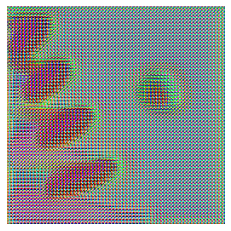

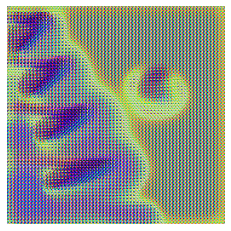

In [35]:
# plot the image
plt.imshow(gen_image1[0])
plt.axis('off')
plt.show()
# plot the image
plt.imshow(gen_image2[0])
plt.axis('off')
plt.show()